In [14]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from corr_lib import sprMat
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 0. Loading data

In [15]:
# Read LVM file from command line
data_path = gui_fpath("Select data directory", "./")
data, behaviour = read_mat(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg/mvg_6/mvg_6_2017_12_12_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (456, 201, 12)


# Cross-Correlation

First attempt at studying the data - autocorrelation. Should give indication at how well the data predicts itself

**Conclusions**:
* Why are there oscillations in the autocorrelation - ah, of course, because of decay-conv :)
* Data significantly autocorrelated - for most channel pairs it is best explained by 0-time-shift. Hence, it is useful to use an autoregressor to predict data

**TODO**:
* *[Priority Low]* See if global brain state can be subtracted somehow. Otherwise, there is significant ambiguity in what predicts what.
* *[Priority Low]* See if convolution time can be estimated from data. See if we can deconvolve 

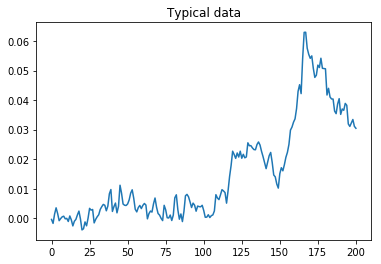

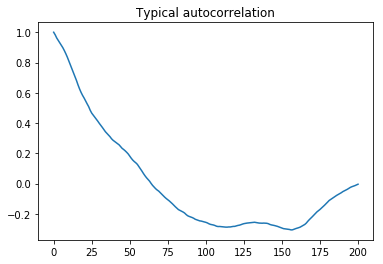

In [16]:
def crosscorr(x, y, withNorm = True):
    xdev = x - np.mean(x)
    ydev = y - np.mean(y)
    rez = np.correlate(xdev, ydev, mode='full')[x.size-1:]
    if withNorm:
        s2_x = np.correlate(xdev, xdev)
        s2_y = np.correlate(ydev, ydev)
        return rez / np.sqrt(s2_x * s2_y)
    else:
        return rez

plt.figure()
plt.title("Typical data")
plt.plot(data[0, :, 2])
plt.show()
    
plt.figure()
plt.title("Typical autocorrelation")
plt.plot(crosscorr(data[0, :, 2], data[0, :, 2]))
plt.show()

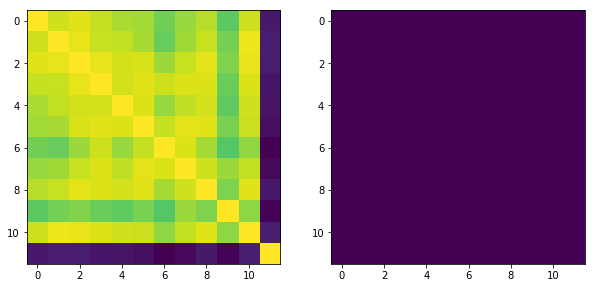

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.951777,0.966734,0.941453,0.914837,0.906593,0.855753,0.896658,0.928385,0.830187,0.948435,0.373259
1,0.951777,1.000000,0.974504,0.944776,0.938307,0.912404,0.844100,0.903667,0.943127,0.859656,0.983766,0.382188
2,0.966734,0.974504,1.000000,0.974573,0.957210,0.960152,0.898794,0.944798,0.971508,0.871570,0.981315,0.378864
3,0.941453,0.944776,0.974573,1.000000,0.954836,0.970613,0.948318,0.965660,0.965423,0.849408,0.963784,0.365542
4,0.914837,0.938307,0.957210,0.954836,1.000000,0.964588,0.897433,0.935265,0.955272,0.836804,0.950411,0.363985
5,0.906593,0.912404,0.960152,0.970613,0.964588,1.000000,0.940559,0.972456,0.970601,0.865166,0.946237,0.353858
6,0.855753,0.844100,0.898794,0.948318,0.897433,0.940559,1.000000,0.960888,0.910681,0.823572,0.888524,0.328180
7,0.896658,0.903667,0.944798,0.965660,0.935265,0.972456,0.960888,1.000000,0.952266,0.899715,0.939085,0.342456
8,0.928385,0.943127,0.971508,0.965423,0.955272,0.970601,0.910681,0.952266,1.000000,0.869644,0.968471,0.374684
9,0.830187,0.859656,0.871570,0.849408,0.836804,0.865166,0.823572,0.899715,0.869644,1.000000,0.886461,0.335609


,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
def crosscorr_multitrial(xx, yy):
    sumautox = np.sum([np.correlate(x - np.mean(x), x - np.mean(x)) for x in xx])
    sumautoy = np.sum([np.correlate(y - np.mean(y), y - np.mean(y)) for y in yy])
    sumcorr = np.sum([crosscorr(x, y, False) for x,y in zip(xx, yy)], axis=0)
    return sumcorr / np.sqrt(sumautox * sumautoy)
    

corr_max  = np.zeros((nChannels, nChannels))
corr_maxt = np.zeros((nChannels, nChannels), dtype=int)

for iCh in range(nChannels):
    for jCh in range(nChannels):
        corr = crosscorr_multitrial(data[:, :, iCh], data[:, :, jCh])#[:25]
        corr_maxt[iCh][jCh] = np.argmax(np.abs(corr))
        corr_max[iCh][jCh]  = corr[corr_maxt[iCh][jCh]]
        

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(corr_max)
ax[1].imshow(corr_maxt)
plt.show()

display(pd.DataFrame(corr_max))
display(pd.DataFrame(corr_maxt))

# Deconvolution

We know that the observable $y$ is approximately the convolution of true variable $x$ with exponential decay. Let us estimate the decay constant. The true convolution equation states that

$$\tau \dot{y} = -y + x$$

We will assume that $x \sim \mathcal{N}(0, \Sigma)$. Using 2nd order time-differences, we get that

$$\tau \frac{y(t+\Delta t) - y(t-\Delta t)}{2 \Delta t} = -y(t) + x(t)$$

We will compute and plot this quantity

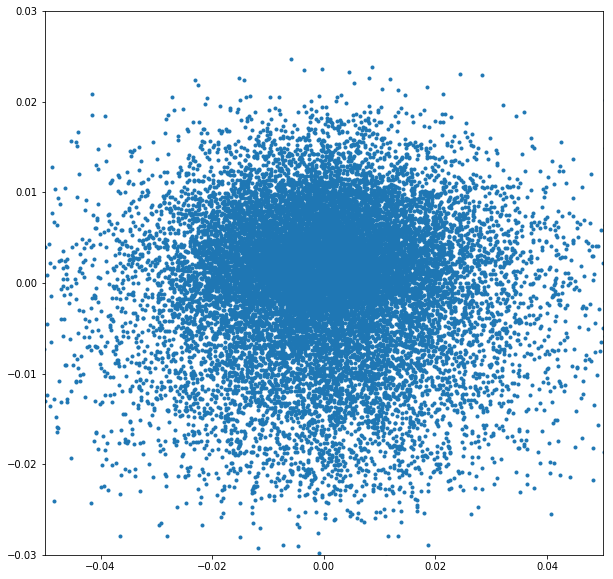

In [75]:
y_prim = []
rhs = []
for iTr in range(100):
    for iCh in range(3,4):#(nChannels):
        y = data[iTr, :, iCh] - np.mean(data[iTr, :, iCh])
#         y_prim += [y[1:] - y[:-1]]
#         rhs += [-(y[1:] + y[:-1])]
        y_prim += [(y[2:] - y[:-2])/(0.2)]
        rhs += [-y[1:-1]]

y_prim = np.array(y_prim).flatten()
rhs = np.array(rhs).flatten()

plt.figure(figsize = (10, 10))
# for yp, r in zip(y_prim, rhs):
plt.plot(y_prim, rhs, '.')
plt.xlim(-0.05, 0.05)
plt.ylim(-0.03, 0.03)
plt.show()